In [5]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro import infer

import matplotlib.pyplot as plt
import arviz as az
import pickle

In [11]:
import antiglitch
from antiglitch import freqs, extract_glitch, fsignal, to_fd, glitch_model, new_model
from antiglitch import rfft, irfft

In [554]:
# Bayesian model

from numpyro import distributions as dist
from antiglitch import CplxNormal

def glitch_model2(freqs, invasd, data=None):
    """Reparamaterised physical model"""
    amp_r = numpyro.sample("amp_r", dist.Normal(0, 400))
    amp_i = numpyro.sample("amp_i", dist.Normal(0, 400))
    amp = numpyro.deterministic("amp", jnp.sqrt(amp_r*amp_r+amp_i*amp_i))
    numpyro.factor('r', -jnp.log(amp))

    tx = numpyro.sample("t_", dist.Beta(2, 2))
    t = numpyro.deterministic("time", 0.01*(2.*tx-1.))
    f0 = numpyro.sample('f0', dist.Uniform(10., 600.))
    gbw = numpyro.sample('gbw', dist.Uniform(0.25, 8.))
    
    raw = invasd*fsignal(freqs, f0, gbw)
    #norm = 1./jnp.sqrt(jnp.sum(jnp.real(raw*raw.conjugate())))

    with numpyro.plate("data", len(data)):
        numpyro.sample("y", CplxNormal((amp_r+1.j*amp_i)*jnp.exp(-2.j*jnp.pi*t*freqs)*raw, 0.5), obs=data)

In [345]:
df1 = pd.read_json('../data/all_PE.json')
df2 = pd.read_json('../data/all_PE_v2.json')

In [346]:
def fixup(row):
    tmp = dict(row)
    tmp['f0'] = row['frequency']
    return tmp

In [347]:
dict1 = {(row['ifo'], row['ml_label'], row['num']): fixup(row)
            for key, row in df1.iterrows()}
dict2 = {(row['ifo'], row['ml_label'], row['num']): fixup(row)
            for key, row in df2.iterrows()}

In [528]:
# An attempt at finding the MAP

num_svi_steps = 10000
from numpyro.infer import SVI, Trace_ELBO, autoguide
optimizer = numpyro.optim.Adam(step_size=1e-3)
guide = autoguide.AutoNormal(glitch_model2, init_loc_fn=infer.init_to_sample)
svi = SVI(glitch_model2, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(jax.random.PRNGKey(101), num_svi_steps, freqs[1:], invasd[1:], data=fglitch[1:])
params, losses = svi_result.params, svi_result.losses

100%|██████████| 10000/10000 [00:07<00:00, 1385.64it/s, init loss: 129330.8906, avg. loss [9501-10000]: 12707.0127]


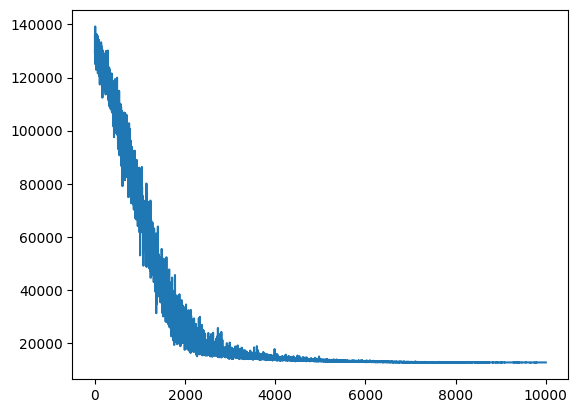

In [529]:
plt.plot(losses)

In [423]:
inf

{'amp_r': -68.58595275878906,
 'amp_i': 0.008540457114577293,
 'f0': 149.6106414794922,
 'gbw': 0.28842926025390625,
 'time': 3.1780316930962726e-05,
 'phase': 3.1414681316326445}

In [424]:
inf

{'amp_r': -68.58595275878906,
 'amp_i': 0.008540457114577293,
 'f0': 149.6106414794922,
 'gbw': 0.28842926025390625,
 'time': 3.1780316930962726e-05,
 'phase': 3.1414681316326445}

In [530]:
params

{'amp_i_auto_loc': Array(-510.75912, dtype=float32),
 'amp_i_auto_scale': Array(1.1926723, dtype=float32),
 'amp_r_auto_loc': Array(-100.11068, dtype=float32),
 'amp_r_auto_scale': Array(3.028056, dtype=float32),
 'f0_auto_loc': Array(-3.7986376, dtype=float32),
 'f0_auto_scale': Array(0.06871238, dtype=float32),
 'gbw_auto_loc': Array(1.6094209, dtype=float32),
 'gbw_auto_scale': Array(0.09707907, dtype=float32),
 't__auto_loc': Array(0.636902, dtype=float32),
 't__auto_scale': Array(0.04280544, dtype=float32)}

In [533]:
tmp = {key.removesuffix('_auto_loc'): val for key, val in params.items()}
tmp['time'] = 0.05*(2.*tmp['t_']-1.)
snip1.set_infer(tmp)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

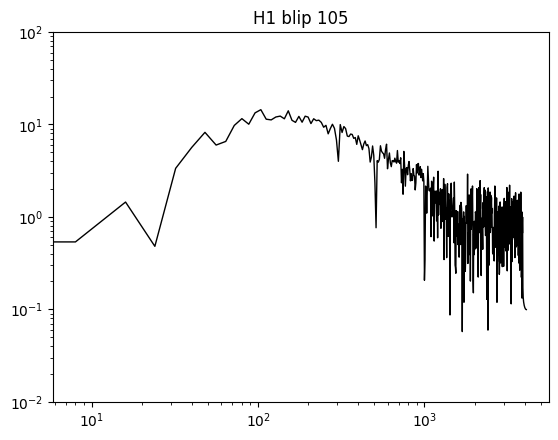

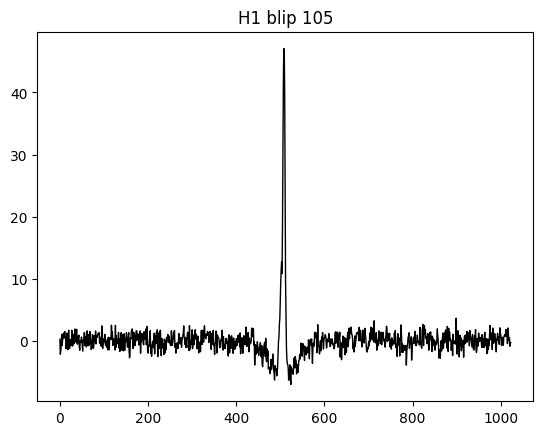

In [534]:
snip1.plot()

In [587]:
# Define Bayesian sampler
sampler = infer.MCMC(
    infer.NUTS(glitch_model2, init_strategy=infer.init_to_median, dense_mass=True),
    num_warmup=2000,
    num_samples=1000,
    num_chains=4,
    progress_bar=True,
)

/local/andrew.lundgren/ipykernel_2238514/3886923524.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(


In [536]:
dt1 = df1.query("ifo == 'H1' and ml_label == 'Blip'")
dt2 = df2.query("ifo == 'H1' and ml_label == 'Blip'")

In [178]:
dt1[dt1['residual'] > 18]

,amp_r,amp_i,frequency,gbw,time,amp_r_sd,amp_i_sd,f0_sd,gbw_sd,time_sd,amp,phase,snr,power,residual,peak_frequency,ifo,ml_label,num
105,-0.409,8.712,375.403,6.610,-0.669,3.962,1.746,17.359,1.016,0.001,8.721595,1.617709,74.605375,23.181297,23.118633,337.794562,H1,Blip,105
174,-66.996,-122.084,400.000,1.291,-0.783,20.552,8.931,0.000,1.158,0.000,139.258634,-2.072694,140.087694,46.886210,21.529786,336.722062,H1,Blip,174
368,-2.104,-3.523,357.525,6.108,-0.661,4.149,3.598,40.640,1.661,0.003,4.103455,-2.109168,58.799081,22.059710,22.033089,330.202306,H1,Blip,368
479,-4.635,4.718,364.266,2.273,-0.671,2.118,2.231,32.089,1.372,0.001,6.613830,2.347321,125.971712,57.403531,57.339413,340.597674,H1,Blip,479
498,2.954,6.038,376.406,6.673,-0.636,4.162,2.903,17.791,1.080,0.002,6.721872,1.115798,74.037704,19.506333,19.461758,368.009188,H1,Blip,498


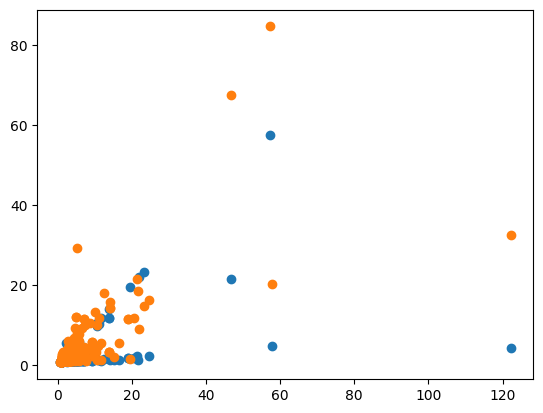

In [179]:
plt.scatter(dt1['power'], dt1['residual'])
plt.scatter(dt2['power'], dt2['residual'])

In [598]:
num = 403
key = ('H1', 'blip', num)
snip1 = antiglitch.Snippet(*key)
snip2 = antiglitch.Snippet(*key)

snip2.set_infer(dict1[('H1', 'Blip', num)])

invasd = snip1.invasd
fglitch = to_fd(snip1.whts)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

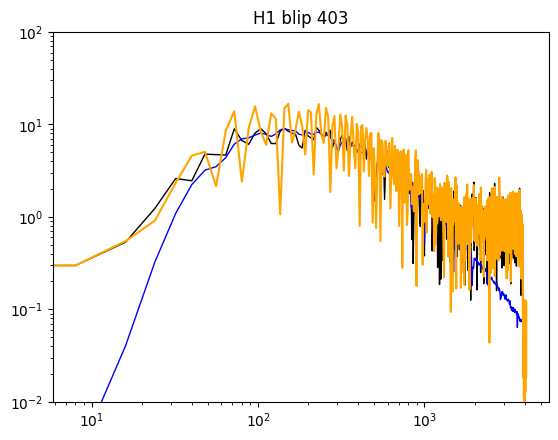

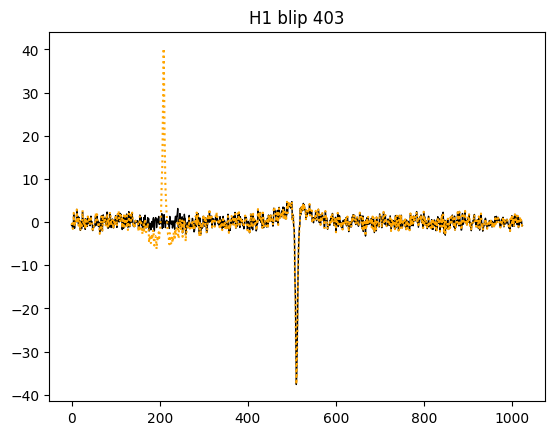

In [599]:
snip2.plot()

In [600]:
sampler.run(jax.random.PRNGKey(0), freqs = freqs[1:], invasd = invasd[1:], data = fglitch[1:])

sample: 100%|██████████| 3000/3000 [00:05<00:00, 547.95it/s, 7 steps of size 2.82e-01. acc. prob=0.95]  


In [610]:
itrace = az.from_numpyro(sampler)
summ = az.summary(itrace, kind='all')
inf_data = itrace
inf = {key: float(np.mean(inf_data.posterior[key]))
        for key in ['amp_r', 'amp_i', 'f0','gbw','time']}
cpamp = inf['amp_r']+1.j*inf['amp_i']
#inf['amp'] = np.abs(cpamp)
inf['phase'] = np.angle(cpamp)

In [621]:
az.summary(itrace, kind='all', round_to=8)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amp,98.860252,1.582348,96.143883,102.181488,2.725502e-02,1.932147e-02,3448.499712,2484.574754,1.001032
amp_i,4.406566,1.498173,1.498919,7.105915,2.531334e-02,1.904624e-02,3522.585829,2352.005007,1.001254
amp_r,-98.750648,1.581449,-101.859924,-95.850685,2.733170e-02,1.937441e-02,3427.576757,2469.005471,1.001092
f0,109.570717,8.005164,93.600204,123.967003,1.409227e-01,9.965643e-02,3253.729194,2422.897611,1.001251
gbw,0.422619,0.028123,0.370787,0.475680,4.899700e-04,3.464900e-04,3265.769001,2196.519396,1.001079
t_,0.490278,0.000302,0.489672,0.490815,4.910000e-06,3.470000e-06,3785.653805,3206.419467,1.000955
time,-0.000194,0.000006,-0.000207,-0.000184,1.000000e-07,7.000000e-08,3785.653805,3206.419467,1.000957


In [611]:
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     amp_i      4.41      1.50      4.39      2.04      6.93   3477.02      1.00
     amp_r    -98.75      1.58    -98.69   -101.32    -96.11   3328.87      1.00
        f0    109.57      8.01    109.73     96.06    122.43   3206.72      1.00
       gbw      0.42      0.03      0.42      0.38      0.47   3277.51      1.00
        t_      0.49      0.00      0.49      0.49      0.49   3769.91      1.00

Number of divergences: 0


In [603]:
snip1.set_infer(inf)

array([[<AxesSubplot: ylabel='amp_i'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='amp_r'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='f0'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='gbw'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='t_'>, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: xlabel='amp', ylabel='time'>,
        <AxesSubplot: xlabel='amp_i'>, <AxesSubplot: xlabel='amp_r'>,
        <AxesSubplot: xlabel='f0'>, <AxesSubplot: xlabel='gbw'>,
        <AxesSubplot: xlabel='t_'>]], dtype=object)

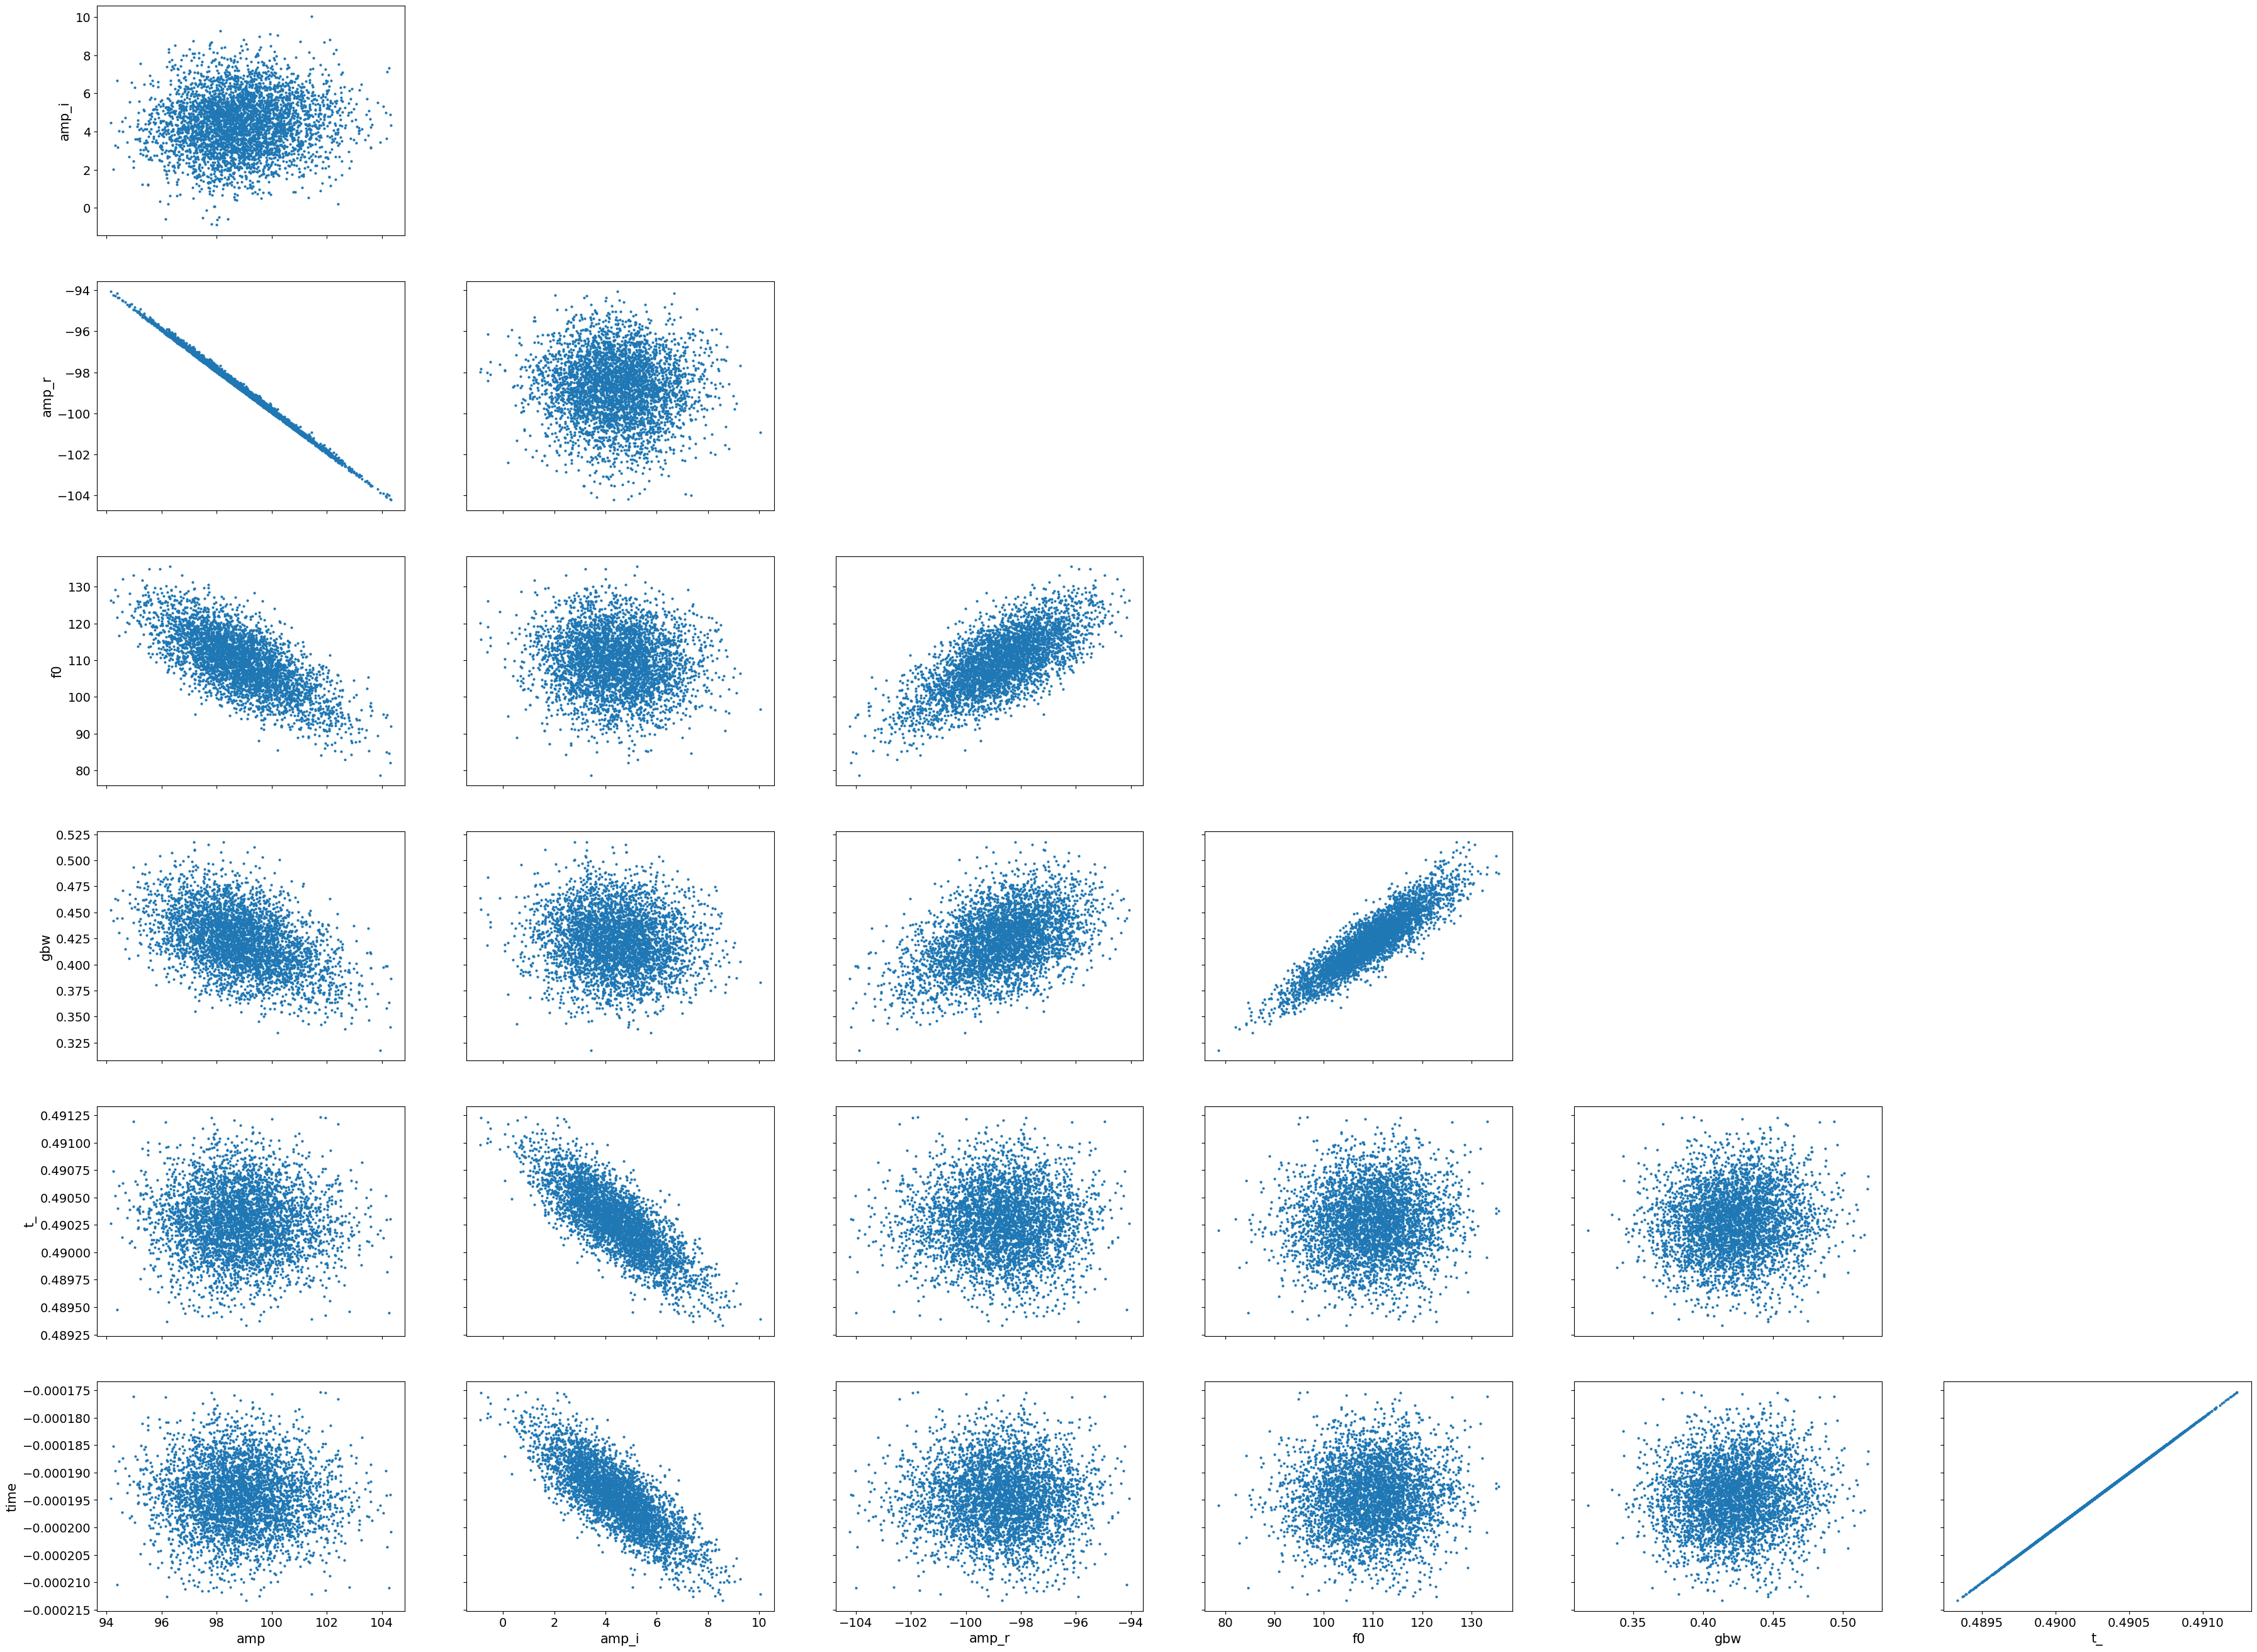

In [604]:
az.plot_pair(itrace)

array([[<AxesSubplot: title={'center': 'amp'}>,
        <AxesSubplot: title={'center': 'amp'}>],
       [<AxesSubplot: title={'center': 'amp_i'}>,
        <AxesSubplot: title={'center': 'amp_i'}>],
       [<AxesSubplot: title={'center': 'amp_r'}>,
        <AxesSubplot: title={'center': 'amp_r'}>],
       [<AxesSubplot: title={'center': 'f0'}>,
        <AxesSubplot: title={'center': 'f0'}>],
       [<AxesSubplot: title={'center': 'gbw'}>,
        <AxesSubplot: title={'center': 'gbw'}>],
       [<AxesSubplot: title={'center': 't_'}>,
        <AxesSubplot: title={'center': 't_'}>],
       [<AxesSubplot: title={'center': 'time'}>,
        <AxesSubplot: title={'center': 'time'}>]], dtype=object)

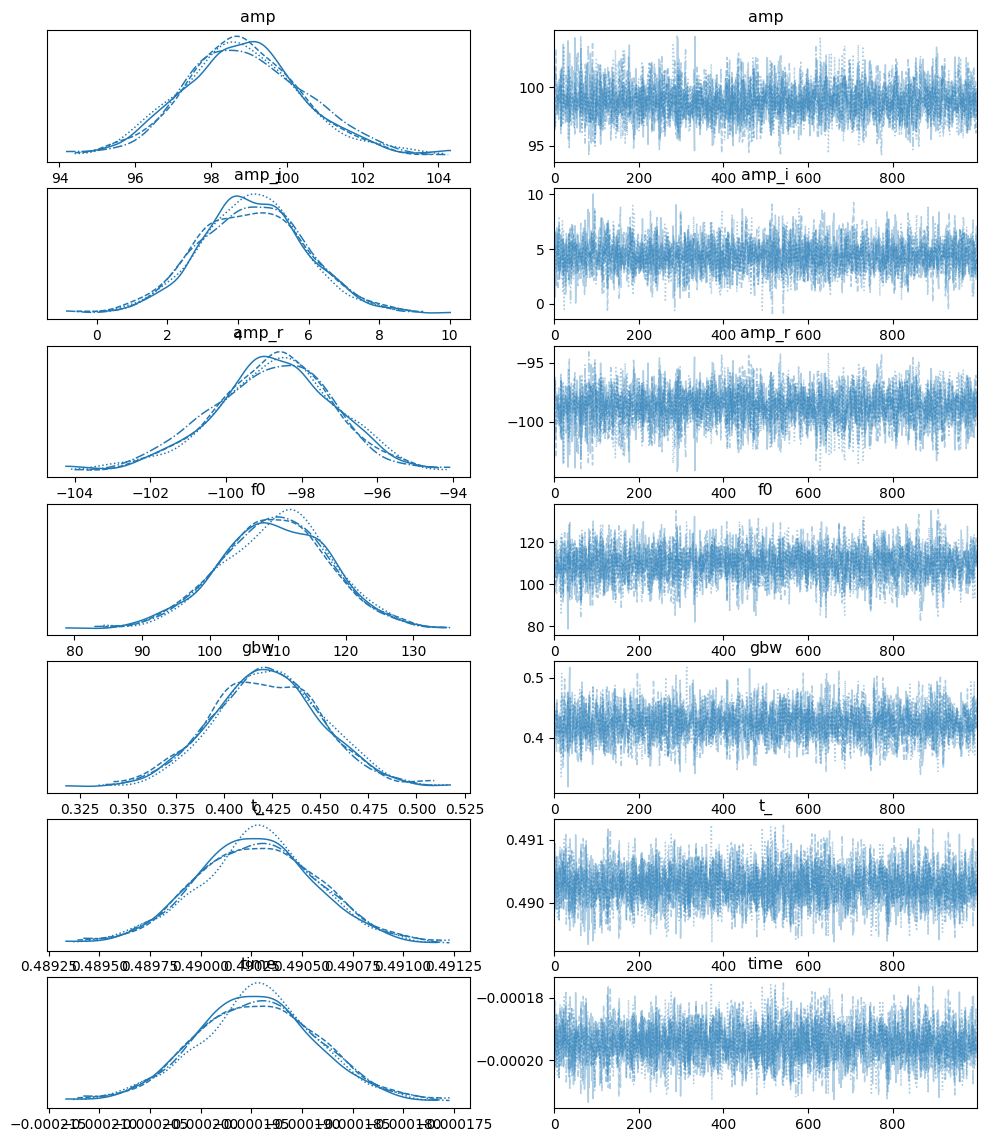

In [605]:
az.plot_trace(itrace)

array([[<AxesSubplot: title={'center': 'amp'}>,
        <AxesSubplot: title={'center': 'amp_i'}>,
        <AxesSubplot: title={'center': 'amp_r'}>],
       [<AxesSubplot: title={'center': 'f0'}>,
        <AxesSubplot: title={'center': 'gbw'}>,
        <AxesSubplot: title={'center': 't_'}>],
       [<AxesSubplot: title={'center': 'time'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

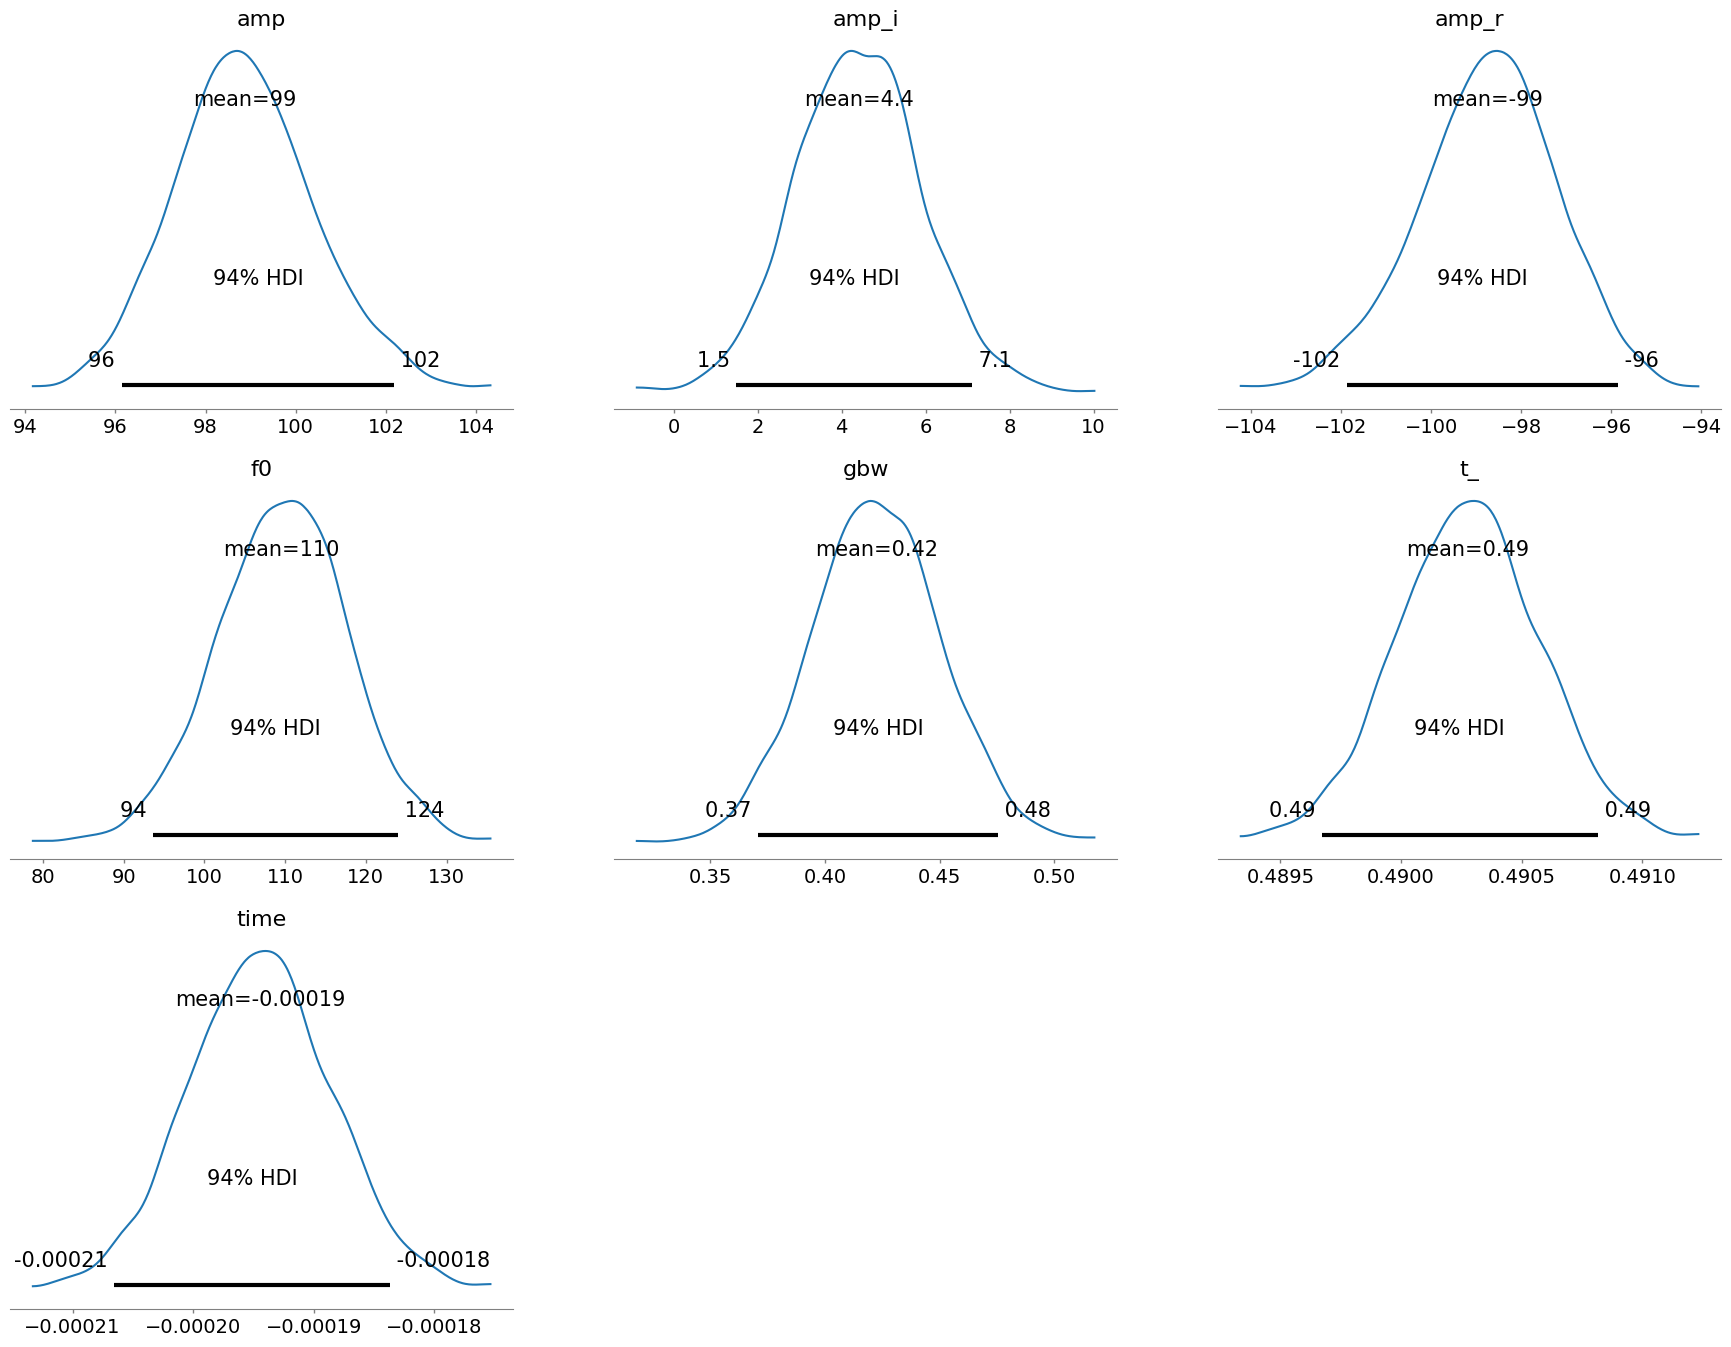

In [606]:
az.plot_posterior(itrace)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

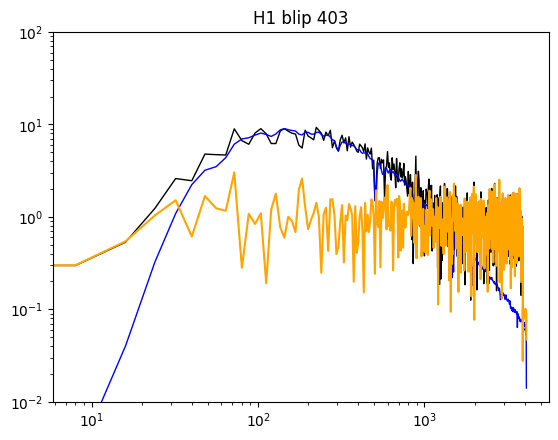

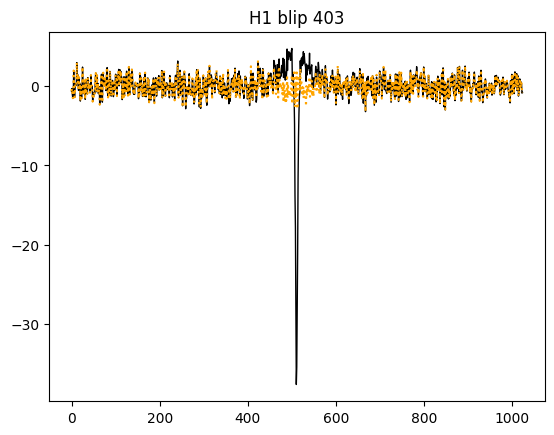

In [607]:
snip1.plot()